In [85]:
import numpy as np
import matplotlib.pyplot as plt
# from umap import UMAP
import os
import sys

from scipy.ndimage import uniform_filter1d
import scipy.io
import requests

In [6]:
# @title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)


In [7]:
# @title Data loading

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


## Import Packages

In [8]:
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA
import sklearn.model_selection as ms
import sklearn.linear_model as lm
import sklearn as sk
from sklearn import linear_model

import random
import seaborn as sns

In [9]:
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten
# from keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import ReLU
# from keras.layers.advanced_activations import Tanh
import tensorflow as tf
import keras

#### z-score

In [10]:
# @title take PCA after preparing data by z-score
Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)

In [11]:
pca_model = PCA(n_components=500)
pca_zscore = pca_model.fit_transform(Z.T)

#### Custom functions

In [12]:
def create_custom_model(input_dim, output_dim, nodes, name='model',activation = ['relu'],activation_out='linear'):
    def create_model():
        # Create model
        model = Sequential(name=name)
        if len(nodes)==0:
            model.add(Dense(output_dim, input_dim=input_dim, activation=activation[0]))
        else:
            model.add(Dense(nodes[0], input_dim=input_dim, activation=activation[0]))
            for i in range(1,len(nodes)):
                model.add(Dense(nodes[i], input_dim=nodes[i-1], activation=activation[i]))
            model.add(Dense(output_dim, activation=activation_out))

        # Compile model
        model.compile(loss='mse',   optimizer='adam')#,   metrics=['mse'])
        return model
    return create_model

In [13]:
def split_dataset(Xdata,Ydata,trials,i,T):
    L = Xdata.shape[0]
    i_0 = i*round(L/trials)
    i_f = i_0 + L-T
    X_tr, X_tst = np.zeros((L-T,Xdata.shape[1])), np.zeros((T,Xdata.shape[1]))
    y_tr, y_tst = np.zeros((L-T,1)), np.zeros((T,1))

    if i_f>L:
        X_tr[0:i_f-L] = Xdata[0:i_f-L]
        X_tr[i_f-L:] = Xdata[i_0:]
        X_tst = Xdata[i_f-L:i_0]
        y_tr[0:i_f-L] = Ydata[0:i_f-L]
        y_tr[i_f-L:] = Ydata[i_0:]
        y_tst = Ydata[i_f-L:i_0]
    elif i_f+T == L:
        X_tr = Xdata[i_0:i_f]
        X_tst = Xdata[i_f:]
        y_tr = Ydata[i_0:i_f]
        y_tst = Ydata[i_f:]
    else:
        X_tr = Xdata[i_0:i_f]
        X_tst[:L-i_f] = Xdata[i_f:]
        X_tst[L-i_f:] = Xdata[:i_0]
        y_tr = Ydata[i_0:i_f]
        y_tst[:L-i_f] = Ydata[i_f:]
        y_tst[L-i_f:] = Ydata[:i_0]

    return X_tr, X_tst, y_tr, y_tst

In [14]:
def general_decoder(XData,yData,pars=[],trials = 15):
    trained_models = []
    MSE = []
    R2 = []
    predictions = []
    
    T = round(len(yData)*0.25)
    L = XData.shape[0]
    for i in range(trials):

        X_train, X_test, y_train, y_test = split_dataset(XData,yData,trials,i,T)
        
        if len(pars)>0:   
            model_tf = create_custom_model(X_train.shape[1], 1, [100,100], name='model_tf',activation = ['relu','tanh'])
            model = model_tf()
            model.fit(X_train,y_train,batch_size=pars[0],epochs=pars[1],verbose=pars[2],validation_data=(X_test, y_test),callbacks=[pars[3]])
        else:
            model = linear_model.LinearRegression()
            model.fit(X_train,y_train)
            
        trained_models.append(model)

        y_pred = model.predict(X_test)
        predictions.append([y_pred,y_test,X_test])
        R2.append(sk.metrics.r2_score(y_test,y_pred))
        MSE.append(sk.metrics.mean_squared_error(y_test,y_pred,squared=False))
                
    return trained_models, MSE, R2, predictions

In [82]:
def general_depth_decoder(z_depth,XData,yData,pars=[],trials = 5, trials_neuron = 5,nonPCA = False):
    
    T = round(len(yData)*0.25)
    L = XData.shape[0]

    pca_layers_zscore = []
    z_values = np.unique(z_depth)

    minimal_neuron_count = min([len(np.where(z_depth == z_values[layer])[0]) for layer in range(len(z_values))]) #number of neurons in the layer which has the least number of neurons
    minimal_neuron_count = round(minimal_neuron_count*0.9) # grab 90% of this number
    
    trained_models = []
    MSE = np.zeros((len(z_values),trials_neuron,trials))
    R2 = np.zeros((len(z_values),trials_neuron,trials))
    predictions = []
    
    for layer in range(len(z_values)):

        trained_models.append([])
        predictions.append([]) 

        for i in range(trials_neuron):

            pca_layer_model = PCA(n_components=500)

            index = np.where(z_depth == z_values[layer])[0]
            random.shuffle(index)

            pca_layers_zscore.append(pca_model.fit_transform(XData[index[:minimal_neuron_count]].T))

            trained_models[-1].append([])
            predictions[-1].append([])

            for j in range(trials):

                X_train, X_test, y_train, y_test = split_dataset(pca_layers_zscore[-1],yData,trials,j,T)

                if len(pars)>0:   
                    model_tf = create_custom_model(X_train.shape[1], 1, [100,100], name='model_tf',activation = ['relu','tanh'])
                    model = model_tf()
                    model.fit(X_train,y_train,batch_size=pars[0],epochs=pars[1],verbose=pars[2],validation_data=(X_test, y_test),callbacks=[pars[3]])
                else:
                    model = linear_model.LinearRegression()
                    model.fit(X_train,y_train)

                trained_models[-1].append(model)

                y_pred = model.predict(X_test)
                predictions[-1].append([y_pred,y_test,X_test])
                R2[layer,i,j] = sk.metrics.r2_score(y_test,y_pred)
                MSE[layer,i,j] = sk.metrics.mean_squared_error(y_test,y_pred,squared=False)
                
                print(layer,i,j)
                
    return trained_models, MSE, R2, predictions

In [16]:
n_epochs = 100
batch_size = 15
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4) #if there is no improvement in validation loss function for "#patience" epochs, then training stops
pars = [batch_size,n_epochs,0,[callback]]

### Pupil Area

In [17]:
trained_models_ffnn, MSE_ffnn, R2_ffnn, predictions_ffnn = general_decoder(pca_zscore,dat['pupilArea'],pars,trials = 15)
trained_models_linear, MSE_linear, R2_linear, predictions_linear = general_decoder(pca_zscore,dat['pupilArea'],[],trials = 15)

In [83]:
trained_models_ffnnDEPTH, MSE_ffnnDEPTH, R2_ffnnDEPTH, predictions_ffnnDEPTH = general_depth_decoder(dat['xyz'][-1],Z,dat['pupilArea'],pars)
trained_models_linearDEPTH, MSE_linearDEPTH, R2_linearDEPTH, predictions_linearDEPTH = general_depth_decoder(dat['xyz'][-1],Z,dat['pupilArea'],[])

0 0 0
0 0 1
0 0 2
0 0 3
0 0 4
0 1 0
0 1 1
0 1 2
0 1 3
0 1 4
0 2 0
0 2 1
0 2 2
0 2 3
0 2 4
0 3 0
0 3 1
0 3 2
0 3 3
0 3 4
0 4 0
0 4 1
0 4 2
0 4 3
0 4 4
1 0 0
1 0 1
1 0 2
1 0 3
1 0 4
1 1 0
1 1 1
1 1 2
1 1 3
1 1 4
1 2 0
1 2 1
1 2 2
1 2 3
1 2 4
1 3 0
1 3 1
1 3 2
1 3 3
1 3 4
1 4 0
1 4 1
1 4 2
1 4 3
1 4 4
2 0 0
2 0 1
2 0 2
2 0 3
2 0 4
2 1 0
2 1 1
2 1 2
2 1 3
2 1 4
2 2 0
2 2 1
2 2 2
2 2 3
2 2 4
2 3 0
2 3 1
2 3 2
2 3 3
2 3 4
2 4 0
2 4 1
2 4 2
2 4 3
2 4 4
3 0 0
3 0 1
3 0 2
3 0 3
3 0 4
3 1 0
3 1 1
3 1 2
3 1 3
3 1 4
3 2 0
3 2 1
3 2 2
3 2 3
3 2 4
3 3 0
3 3 1
3 3 2
3 3 3
3 3 4
3 4 0
3 4 1
3 4 2
3 4 3
3 4 4
4 0 0
4 0 1
4 0 2
4 0 3
4 0 4
4 1 0
4 1 1
4 1 2
4 1 3
4 1 4
4 2 0
4 2 1
4 2 2
4 2 3
4 2 4
4 3 0
4 3 1
4 3 2
4 3 3
4 3 4
4 4 0
4 4 1
4 4 2
4 4 3
4 4 4
5 0 0
5 0 1
5 0 2
5 0 3
5 0 4
5 1 0
5 1 1
5 1 2
5 1 3
5 1 4
5 2 0
5 2 1
5 2 2
5 2 3
5 2 4
5 3 0
5 3 1
5 3 2
5 3 3
5 3 4
5 4 0
5 4 1
5 4 2
5 4 3
5 4 4
6 0 0
6 0 1
6 0 2
6 0 3
6 0 4
6 1 0
6 1 1
6 1 2
6 1 3
6 1 4
6 2 0
6 2 1
6 2 2
6 2 3
6 2 4
6 3 0
6 3 

#### Plots

Text(0, 0.5, '$R^2$')

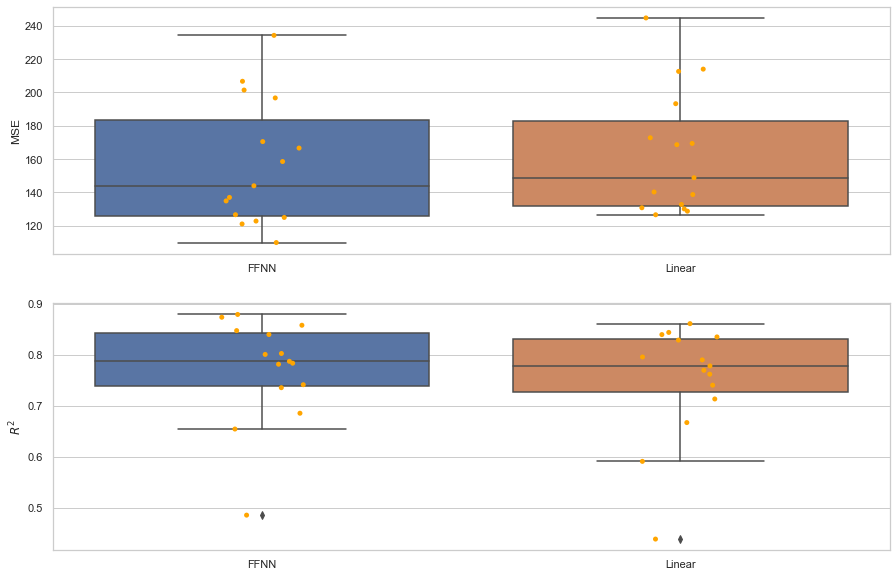

In [96]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(15,10))
pass

plt.subplot(2,1,1)
ax = sns.boxplot(data=[MSE_ffnn,MSE_linear])
ax = sns.stripplot(data=[MSE_ffnn,MSE_linear],color='orange')
ax.set_xticks([0,1])
ax.set_xticklabels(['FFNN','Linear'])#, minor=False, rotation=45)
plt.ylabel('MSE')

plt.subplot(2,1,2)
ax = sns.boxplot(data=[R2_ffnn,R2_linear])
ax = sns.stripplot(data=[R2_ffnn,R2_linear],color='orange')
ax.set_xticks([0,1])
ax.set_xticklabels(['FFNN','Linear'])#, minor=False, rotation=45)
plt.ylabel('$R^2$')

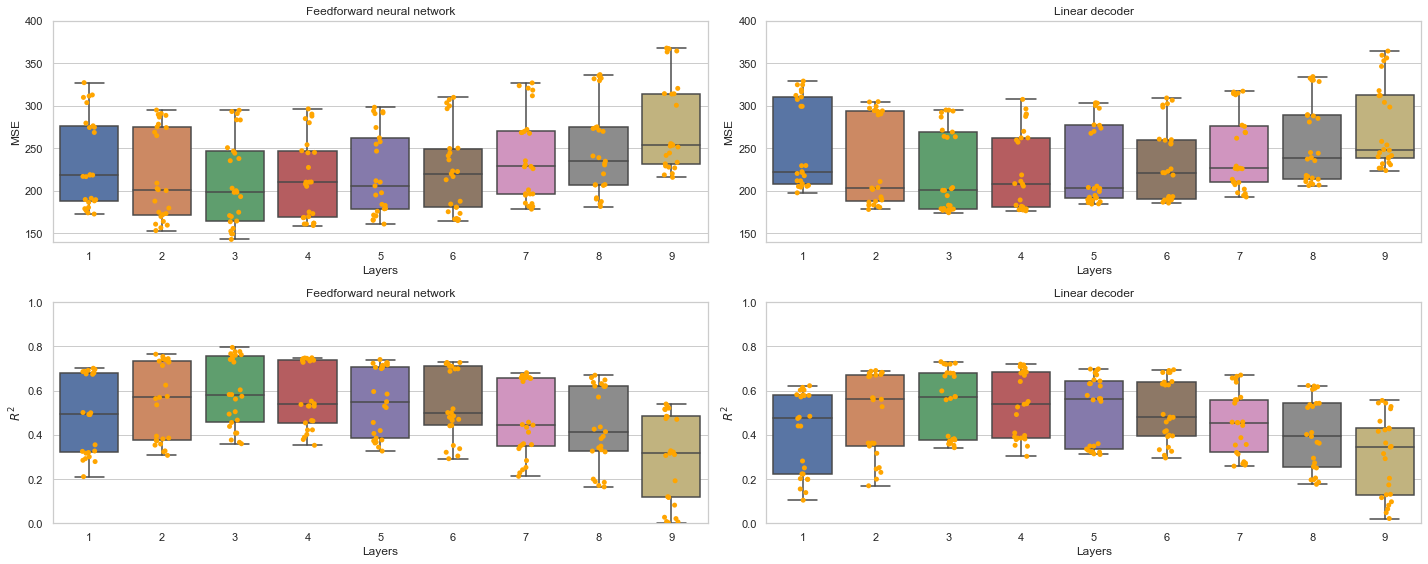

In [95]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(20,8))
pass

DATA_MSEffnn = []
for i in range(len(MSE_ffnnDEPTH)):
    DATA_MSEffnn.append([x for K in MSE_ffnnDEPTH[i] for x in K])

DATA_R2ffnn = []
for i in range(len(R2_ffnnDEPTH)):
    DATA_R2ffnn.append([x for K in R2_ffnnDEPTH[i] for x in K])

DATA_MSElinear = []
for i in range(len(MSE_linearDEPTH)):
    DATA_MSElinear.append([x for K in MSE_linearDEPTH[i] for x in K])

DATA_R2linear = []
for i in range(len(R2_linearDEPTH)):
    DATA_R2linear.append([x for K in R2_linearDEPTH[i] for x in K])

plt.subplot(2,2,1)
ax = sns.boxplot(data=DATA_MSEffnn)
ax = sns.stripplot(data=DATA_MSEffnn,color='orange')
ax.set_xticks([0,1,2,3,4,5,6,7,8])
ax.set_xticklabels(list(range(1,10)))
plt.ylabel('MSE')
plt.xlabel('Layers')
plt.title('Feedforward neural network')
plt.ylim([140,400])

plt.subplot(2,2,2)
ax = sns.boxplot(data=DATA_MSElinear)
ax = sns.stripplot(data=DATA_MSElinear,color='orange')
ax.set_xticks([0,1,2,3,4,5,6,7,8])
ax.set_xticklabels(list(range(1,10)))
plt.ylabel('MSE')
plt.xlabel('Layers')
plt.title('Linear decoder')
plt.ylim([140,400])

plt.subplot(2,2,3)
ax = sns.boxplot(data=DATA_R2ffnn)
ax = sns.stripplot(data=DATA_R2ffnn,color='orange')
ax.set_xticks([0,1,2,3,4,5,6,7,8])
ax.set_xticklabels(list(range(1,10)))
plt.ylabel('$R^2$')
plt.xlabel('Layers')
plt.title('Feedforward neural network')
plt.ylim([0,1])

plt.subplot(2,2,4)
ax = sns.boxplot(data=DATA_R2linear)
ax = sns.stripplot(data=DATA_R2linear,color='orange')
ax.set_xticks([0,1,2,3,4,5,6,7,8])
ax.set_xticklabels(list(range(1,10)))
plt.ylabel('$R^2$')
plt.xlabel('Layers')
plt.title('Linear decoder')
plt.ylim([0,1])

plt.tight_layout()

#### Speed

In [84]:
SPEEDtrained_models_ffnn, SPEEDMSE_ffnn, R2_ffnn, predictions_ffnn = general_decoder(pca_zscore,dat['run'],pars)
SPEEDtrained_models_linear, MSE_linear, R2_linear, predictions_linear = general_decoder(pca_zscore,dat['run'],[])

KeyboardInterrupt: 

In [ ]:
SPEEDtrained_models_ffnnDEPTH, SPEEDMSE_ffnnDEPTH, R2_ffnnDEPTH, predictions_ffnnDEPTH= general_depth_decoder(dat['xyz'][-1],Z,dat['run'],pars)
SPEEDtrained_models_linearDEPTH, MSE_lineaDEPTHr, R2_linearDEPTH, predictions_linearDEPTH = general_depth_decoder(dat['xyz'][-1],Z,dat['run'],[])